In [53]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
path_to_data = '/gpfs01/euler/data/Data/Behrens_Hoefling/export/yr/'

In [77]:
path_to_seq = '/gpfs01/euler/User/ydeng/data/MouseCamCorrected/left/RandomSequences.npy'

In [78]:
seq = np.load(path_to_seq)

In [80]:
seq.shape

(108, 20)

In [81]:
seq_09 = seq[:,9]

In [84]:
seq_09,seq_19

(array([ 57,  95,  24,  68, 105,  89,  22,  78,  58,  39,   7,  71,  42,
         45,  81,  12,  93,  55,  85,   2,  16,  33,  56,  14,  82,  54,
         53,  17,  34,  70,  60,  11, 100,  19,   9,  25,   3,  84,  18,
         76,  40,  29,  47,  23,  98,  44,  10,  96,  27, 106,  59,   5,
         49,  46,  99,  43,  32,  64,  36,  65,  20,  73,  87,  86,  62,
         26,  75,  72,  15,  61,   8,  80, 102, 103,  91, 101,   1,  13,
         69,  21,  30,  52,  63,   6,  74, 107,  31, 104,  48,  90,   4,
         88,  83,  41,  50,   0,  67,  38,  94,  35,  28,  79,  37,  66,
         97,  51,  77,  92], dtype=uint8),
 array([  5,  51,  97,  78,  33, 100,  42,  84,  43,  37,  13, 101,  69,
         25,  67,   7,  52,  86,   1,  79,  65,  63,  44,   8,  30,  91,
        106,  59,   9,  95,  57,  16,  22,  62,  28,  74,  76,  23,  82,
         14,  49,   2,  19,  53,  39, 104,  47,  73,  32,  10,  35,  61,
         93,  26,  55,  36,  66,  40,  98,  15,  17,  60,  99,  70,  41,
        

In [83]:
seq_19 = seq[:,19]

In [18]:
os.listdir(path_to_data)

['val_targets.pkl',
 'train_targets.pkl',
 'val_inputs.pkl',
 'test_inputs.pkl',
 'data_export_yr_clean.ipynb',
 'train_inputs.pkl',
 'test_targets.pkl']

In [2]:
'''
Information about the dataset

#uv and green?
#input downscale from 72 to 18? (input-mean)/std?
#input with no preprocessing, to keep it consistent with autoencoder model where downscale from 56 to 28, input-mean
#how many time lags? ... 30 time lags
'mean': 36.979288270899204, 'sd': 36.98463253226166

These fields may use different random seed of stimulus presentation sequence
"1_ventral1_20210929": 07
"2_ventral1_20210929": 10
"1_ventral2_20210929": 08
"2_ventral2_20210929": 18
"3_ventral2_20210929": 19
"4_ventral2_20210929": 09
"5_ventral2_20210929": 19
"1_ventral1_20210930": 05
"1_ventral2_20210930": 07
"2_ventral2_20210930": 06
"3_ventral2_20210930": 09
'''

'\nInformation about the dataset\n\n#uv and green?\n#input downscale from 72 to 18? (input-mean)/std?\n#input with no preprocessing, to keep it consistent with autoencoder model where downscale from 56 to 28, input-mean\n#how many time lags? ... 30 time lags\n\'mean\': 36.979288270899204, \'sd\': 36.98463253226166\n\nThese fields may use different random seed of stimulus presentation sequence\n"1_ventral1_20210929": 07\n"2_ventral1_20210929": 10\n"1_ventral2_20210929": 08\n"2_ventral2_20210929": 18\n"3_ventral2_20210929": 19\n"4_ventral2_20210929": 09\n"5_ventral2_20210929": 19\n"1_ventral1_20210930": 05\n"1_ventral2_20210930": 07\n"2_ventral2_20210930": 06\n"3_ventral2_20210930": 09\n'

In [19]:
with open(path_to_data+'train_inputs.pkl', "rb") as f:
    train_inputs = pkl.load(f)
with open(path_to_data+'train_targets.pkl', "rb") as f:
    train_targest = pkl.load(f)

with open(path_to_data+'test_inputs.pkl', "rb") as f:
    test_inputs = pkl.load(f)
with open(path_to_data+'test_targets.pkl', "rb") as f:
    test_targest = pkl.load(f)

In [20]:
train_inputs.keys()

dict_keys(['1_ventral1_20210929', '2_ventral1_20210929', '1_ventral2_20210929', '2_ventral2_20210929', '3_ventral2_20210929', '4_ventral2_20210929', '5_ventral2_20210929', '1_ventral1_20210930', '1_ventral2_20210930', '2_ventral2_20210930', '3_ventral2_20210930'])

In [21]:
field_name = '4_ventral2_20210929'

In [22]:
datamean, datasd = 36.98, 36.98

In [24]:
train_inputs[field_name].shape

torch.Size([2, 16200, 72, 64])

In [65]:
train_input1.shape

(16200, 2, 72, 64)

In [91]:
# random seq 09
train_input_09 = np.transpose((np.around(train_inputs['3_ventral2_20210930'].cpu().detach().numpy()*datasd+datamean)).astype(int), (1,0,2,3))

In [92]:
# random seq 19
train_input_19 = np.transpose((np.around(train_inputs['3_ventral2_20210929'].cpu().detach().numpy()*datasd+datamean)).astype(int), (1,0,2,3))

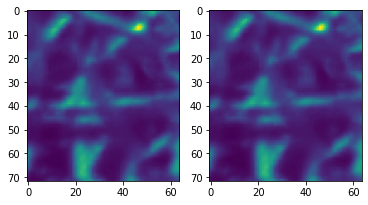

In [93]:
plt.subplot(121)
plt.imshow(train_input_09[0,0,:,:])
plt.subplot(122)
plt.imshow(train_input_19[0,0,:,:])

In [94]:
train_input_09[0,0,:,:] == train_input_19[0,0,:,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [28]:
train_response1 = train_targest[field_name].cpu().detach().numpy()
train_response1.shape

(16200, 86)

In [35]:
np.min(train_input1,axis=(0,2,3)),np.max(train_input1,axis=(0,2,3)) # green+UV

(array([14,  5]), array([255, 255]))

In [30]:
test_input1 = np.transpose((np.around(test_inputs[field_name].cpu().detach().numpy()*datasd+datamean)).astype(int), (1,0,2,3))
test_response1 = test_targest[field_name].cpu().detach().numpy()
print(test_input1.shape,test_response1.shape)

(750, 2, 72, 64) (750, 86)


In [36]:
np.min(test_input1,axis=(0,2,3)),np.max(test_input1,axis=(0,2,3)) # green+UV

(array([14,  5]), array([255, 255]))

#### resize images

In [37]:
scale = 0.5

#### for train input

In [52]:
temps = np.zeros((train_input1.shape[0], train_input1.shape[1],
                  int(train_input1.shape[2]*scale),\
                  int(train_input1.shape[3]*scale)), dtype=np.uint8)
print(temps.shape)

(16200, 2, 36, 32)


In [69]:
for ii in range(len(temps)):
    temp = np.zeros((train_input1.shape[2], train_input1.shape[3],3), dtype=np.uint8)
    temp[:,:,:2]=np.transpose(train_input1[ii], (1,2,0))
    temp = np.uint8(np.around((cv2.resize(temp/255.0, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA))*255.0))
    temps[ii] = np.transpose(temp[:,:,:2], (2,0,1))

In [71]:
train_input1 = np.copy(temps)

In [72]:
print (train_input1.shape, np.min(train_input1,axis=(0,2,3)), np.max(train_input1)) 

(16200, 2, 36, 32) [14  5] 255


#### for test input

In [73]:
del temps
temps = np.zeros((test_input1.shape[0], test_input1.shape[1], 
                  int(test_input1.shape[2]*scale),\
                  int(test_input1.shape[3]*scale)), dtype=np.uint8)

In [74]:
for ii in range(len(temps)):
    temp = np.zeros((test_input1.shape[2], test_input1.shape[3],3), dtype=np.uint8)
    temp[:,:,:2]=np.transpose(test_input1[ii], (1,2,0))
    temp = np.uint8(np.around((cv2.resize(temp/255.0, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA))*255.0))
    temps[ii] = np.transpose(temp[:,:,:2], (2,0,1))
test_input1 = np.copy(temps)
print (test_input1.shape, np.min(test_input1,axis=(0,2,3)), np.max(test_input1))
del temps

(750, 2, 36, 32) [14  5] 255


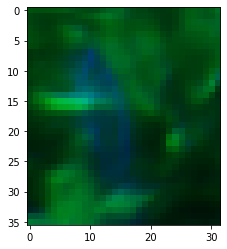

In [75]:
tempbgr = np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(test_input1[370],(1,2,0))[...,::-1]
plt.imshow(tempbgr[:,:,::-1])

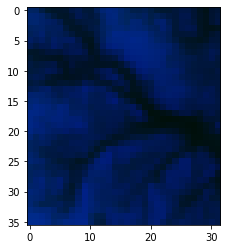

In [76]:
tempbgr = np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(train_input1[1300],(1,2,0))[...,::-1]
plt.imshow(tempbgr[:,:,::-1])

# Generate data loader for model training

In [88]:
def get_sdm(stim, nlag):    
    """
    Get stimulus design matrix. 
    ::nlag: time lag, how many frames of the stimulus we 
            assumed to trigger the response. nlag = 5 is good enough for
            our data.
    """
    n_samples = stim.shape[0] # 162000
    n_features = stim.shape[1:] # 36 32
    frames = np.zeros([n_samples, np.prod(n_features) * nlag])
    for i in range(n_samples): # 162000
        if i < nlag-1: # the first 149/162000 frames
            pad = np.zeros([nlag-i-1, *n_features])
            frame = np.ravel(np.vstack([pad, stim[:i+1]]))
        else:
            frame = np.ravel(stim[i-nlag+1:i+1])
        frames[i] = frame
    return frames

## time lag 50

### testing area time lag 150

In [85]:
nt = 150 # time lag
nh = 36
nw = 32
dims = [nt, nh, nw] # 50 36 32

##### UV channel

In [86]:
Stim = train_input1[:,1,:,:];Stim.shape

(16200, 36, 32)

In [90]:
Stim.shape[1:]

(36, 32)

In [89]:
X_UV = get_sdm(Stim, nt)

In [94]:
# save train and test stimulus separately
nt = 50 # time lag
nh = 36
nw = 32
dims = [nt, nh, nw] # 50 36 32

Stim = train_input1[:,1,:,:]
X_UV = get_sdm(Stim, nt)
X_UV = np.reshape(X_UV,(-1,nt,nh,nw))
X_UV = np.expand_dims(X_UV,axis=1)
Stim=train_input1[:,0,:,:]
X_G = get_sdm(Stim, nt)
X_G = np.reshape(X_G,(-1,nt,nh,nw))
X_G = np.expand_dims(X_G,axis=1)
train_input2 = np.concatenate((X_UV,X_G),axis=1).astype(np.uint8) # UV+g
print (train_input2.shape) # shape: batch_size,color_channel,time_lags,height,width
#
Stim = test_input1[:,1,:,:]
X_UV = get_sdm(Stim, nt)
X_UV = np.reshape(X_UV,(-1,nt,nh,nw))
X_UV = np.expand_dims(X_UV,axis=1)
Stim=test_input1[:,0,:,:]
X_G = get_sdm(Stim, nt)
X_G = np.reshape(X_G,(-1,nt,nh,nw))
X_G = np.expand_dims(X_G,axis=1)
test_input2=np.concatenate((X_UV,X_G),axis=1).astype(np.uint8) #UV+g
print (test_input2.shape) # shape: batch_size,color_channel,time_lags,height,width

(16200, 2, 50, 36, 32)
(750, 2, 50, 36, 32)


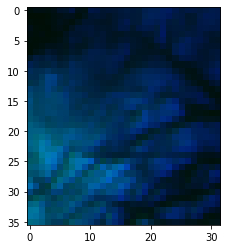

In [96]:
tempbgr=np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(train_input2[370,:,10],(1,2,0))
plt.imshow(tempbgr[:,:,::-1])

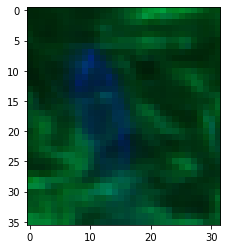

In [97]:
tempbgr=np.zeros((36,32,3),np.uint8)
tempbgr[:,:,:2]=np.transpose(test_input2[370,:,10],(1,2,0))
plt.imshow(tempbgr[:,:,::-1])

In [98]:
#np.save('natural_20210929ventral_train_input_tlag50.npy', train_input2)
#np.save('natural_20210929ventral_test_input_tlag50.npy', test_input2)

In [95]:
np.max(test_input2), np.min(test_input2[50:])

(255, 5)